In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from glob import glob
import pickle

from PIL import ImageColor
import matplotlib.colors

from utils import NN_FEATURES_DIR, RESULTS_DIR, SUBJECTS, NUM_TEST_STIMULI
from analyses.ridge_regression_decoding import NUM_CV_SPLITS, DECODER_OUT_DIR, calc_rsa, calc_rsa_images, calc_rsa_captions, get_fmri_data, pairwise_accuracy, ACC_MODALITY_AGNOSTIC, ACC_CAPTIONS, ACC_IMAGES, get_default_features, get_default_vision_features, get_default_lang_features, MOD_SPECIFIC_IMAGES, MOD_SPECIFIC_CAPTIONS
from notebook_utils import add_avg_subject, create_result_graph, plot_metric_catplot, plot_metric, load_results_data, ACC_MEAN

# Zero-shot cross-modal decoding

In [2]:
models = ["random-flava", "clip", "flava", "imagebind", "blip2"]
all_data = load_results_data(models)


100%|██████████| 1271/1271 [00:26<00:00, 47.93it/s]


In [3]:
data_models = all_data.copy()

data_models = data_models[pd.isna(data_models["mask"])]
data_models = data_models[data_models.surface == False]

data_models

,alpha,model,subject,features,vision_features,lang_features,training_mode,mask,num_voxels,metric,value,surface,resolution,model_feat
0,100000.0,blip2,sub-01,avg,vision_features_cls,lang_features_cls,modality-agnostic,None,162649,pairwise_acc_modality_agnostic,0.868323,False,NaN,blip2_avg
1,100000.0,blip2,sub-01,avg,vision_features_cls,lang_features_cls,modality-agnostic,None,162649,pairwise_acc_captions,0.836853,False,NaN,blip2_avg
2,100000.0,blip2,sub-01,avg,vision_features_cls,lang_features_cls,modality-agnostic,None,162649,pairwise_acc_images,0.942029,False,NaN,blip2_avg
3,100000.0,blip2,sub-01,avg,vision_features_cls,lang_features_cls,modality-agnostic,None,162649,pairwise_acc_mean,0.889441,False,NaN,blip2_avg
4,100000.0,blip2,sub-01,avg,vision_features_cls,lang_features_mean,modality-agnostic,None,162649,pairwise_acc_modality_agnostic,0.866356,False,NaN,blip2_avg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2323,100000.0,random-flava,sub-07,concat,vision_features_cls,lang_features_mean,images,None,214739,pairwise_acc_mean,0.658178,False,NaN,random-flava_concat
2324,100000.0,random-flava,sub-07,matched,vision_features_cls,lang_features_cls,images,None,214739,pairwise_acc_modality_agnostic,0.595963,False,fsaverage7,random-flava_matched
2325,100000.0,random-flava,sub-07,matched,vision_features_cls,lang_features_cls,images,None,214739,pairwise_acc_captions,0.500414,False,fsaverage7,random-flava_matched
2326,100000.0,random-flava,sub-07,matched,vision_features_cls,lang_features_cls,images,None,214739,pairwise_acc_images,0.704555,False,fsaverage7,random-flava_matched


In [4]:
data_cls_feats = data_models.copy()
for model in all_data.model.unique():
    data_cls_feats = data_cls_feats[((data_cls_feats.model == model) & (data_cls_feats.vision_features == "vision_features_cls") & (data_cls_feats.lang_features == "lang_features_cls")) | (data_cls_feats.model != model)]
    
data_matched_feats = data_cls_feats[data_cls_feats.features == "matched"]
data_matched_feats

,alpha,model,subject,features,vision_features,lang_features,training_mode,mask,num_voxels,metric,value,surface,resolution,model_feat
56,100000.0,blip2,sub-01,matched,vision_features_cls,lang_features_cls,modality-agnostic,None,162649,pairwise_acc_modality_agnostic,0.862836,False,NaN,blip2_matched
57,100000.0,blip2,sub-01,matched,vision_features_cls,lang_features_cls,modality-agnostic,None,162649,pairwise_acc_captions,0.805590,False,NaN,blip2_matched
58,100000.0,blip2,sub-01,matched,vision_features_cls,lang_features_cls,modality-agnostic,None,162649,pairwise_acc_images,0.931470,False,NaN,blip2_matched
59,100000.0,blip2,sub-01,matched,vision_features_cls,lang_features_cls,modality-agnostic,None,162649,pairwise_acc_mean,0.868530,False,NaN,blip2_matched
80,100000.0,clip,sub-01,matched,vision_features_cls,lang_features_cls,modality-agnostic,None,162649,pairwise_acc_modality_agnostic,0.872981,False,NaN,clip_matched
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2311,100000.0,imagebind,sub-07,matched,vision_features_cls,lang_features_cls,images,None,214739,pairwise_acc_mean,0.850518,False,NaN,imagebind_matched
2324,100000.0,random-flava,sub-07,matched,vision_features_cls,lang_features_cls,images,None,214739,pairwise_acc_modality_agnostic,0.595963,False,fsaverage7,random-flava_matched
2325,100000.0,random-flava,sub-07,matched,vision_features_cls,lang_features_cls,images,None,214739,pairwise_acc_captions,0.500414,False,fsaverage7,random-flava_matched
2326,100000.0,random-flava,sub-07,matched,vision_features_cls,lang_features_cls,images,None,214739,pairwise_acc_images,0.704555,False,fsaverage7,random-flava_matched


In [5]:
def add_mean_cross_modal_and_within_modal_rows(data):
    extra_rows = []
    for model in data.model.unique():
        for mask in data["mask"].unique():
            for subject in SUBJECTS:
                data_model_subj = data[(data.model == model) & (data.subject == subject)]
                if pd.isna(mask):
                    data_model_subj = data_model_subj[pd.isna(data_model_subj['mask'])]
                else:
                    data_model_subj = data_model_subj[data_model_subj['mask'] == mask]
                # cross-modal
                cross_modal_train_images_eval_captions = data_model_subj[(data_model_subj.training_mode == "images") & (data_model_subj.metric == ACC_CAPTIONS)]
                cross_modal_train_captions_eval_images = data_model_subj[(data_model_subj.training_mode == "captions") & (data_model_subj.metric == ACC_IMAGES)]
        
                if len(cross_modal_train_captions_eval_images) > 0:
                    assert len(cross_modal_train_images_eval_captions) == len(cross_modal_train_captions_eval_images) == 1
                    mean_acc = (cross_modal_train_images_eval_captions.value.item() + cross_modal_train_captions_eval_images.value.item()) / 2
            
                    mean_row = cross_modal_train_images_eval_captions.copy()
                    mean_row["training_mode"] = "cross-modal"
                    mean_row["metric"] = "mean"
                    mean_row["value"] = mean_acc
                    mean_row["condition"] = "cross-modal"
        
                    extra_rows.append(mean_row)
        
                # within-modal
                within_modal_captions = data_model_subj[(data_model_subj.training_mode == "captions") & (data_model_subj.metric == ACC_CAPTIONS)]
                within_modal_images = data_model_subj[(data_model_subj.training_mode == "images") & (data_model_subj.metric == ACC_IMAGES)]
        
                if len(within_modal_captions) > 0:
                    assert len(within_modal_captions) == len(within_modal_images) == 1
                    mean_acc = (within_modal_captions.value.item() + within_modal_images.value.item()) / 2
            
                    mean_row = within_modal_captions.copy()
                    mean_row["training_mode"] = "within-modal"
                    mean_row["metric"] = "mean"
                    mean_row["value"] = mean_acc
                    mean_row["condition"] = "within-modal"
        
                    extra_rows.append(mean_row)

    if len(extra_rows) > 0:
        extra_rows = pd.concat(extra_rows)
        data = pd.concat((data, extra_rows), ignore_index=True)
    return data
    # data_matched_with_mean[data_matched_with_mean.metric == "mean"]

In [6]:
data_matched_feats = add_mean_cross_modal_and_within_modal_rows(data_matched_feats)

In [7]:
DEFAULT_FEAT_OPTIONS = ["vision", "lang", "matched"]

def calc_model_feat_order(data, model_order, feat_options=DEFAULT_FEAT_OPTIONS):
    all_model_feats = data.model_feat.unique()
    all_models = data.model.unique()
    for model in all_models:
        if model not in model_order:
            raise RuntimeError(f"Model missing in order: {model}")
    model_feat_order = []
    for model in model_order:
        for feats in feat_options:
            model_feat = f"{model}_{feats}"
            if model_feat in all_model_feats:
                model_feat_order.append(model_feat)

    return model_feat_order

In [8]:
def create_zero_shot_cross_modal_plot(data, x_variable, ylim=(0.5, 1)):
    sns.set(font_scale=1.6)
    TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
    FEAT_ORDER = ["vision models", "language models", "multimodal models"]
    
    data_to_plot = data.copy()
    
    data_to_plot = data_to_plot[data_to_plot.training_mode != "modality-agnostic"]
    
    data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models", "matched": "multimodal models"})
    
    data_to_plot.loc[((data_to_plot.training_mode == "images") & (data_to_plot.metric == ACC_CAPTIONS)) | ((data_to_plot.training_mode == "captions") & (data_to_plot.metric == ACC_IMAGES)), "condition"] = "cross-modal"
    data_to_plot.loc[((data_to_plot.training_mode == "captions") & (data_to_plot.metric == ACC_CAPTIONS)) | ((data_to_plot.training_mode == "images") & (data_to_plot.metric == ACC_IMAGES)), "condition"] = "within-modal"
    
    # model_feat_order = calc_model_feat_order(data_to_plot, model_order)
    
    
    metrics_order = [ACC_CAPTIONS, ACC_IMAGES, "mean"]
    
    height = 4.5
    aspect = 4
    
    condition_order = ["cross-modal", "within-modal"]
    
    for mode in ["captions", "images", "cross-modal", "within-modal"]:
        data_mode = data_to_plot[data_to_plot.training_mode == mode]
        for x_variable_value in data_to_plot[x_variable].unique():
            for condition in condition_order:
                length = len(data_mode[(data_mode[x_variable] == x_variable_value) & (data_mode.condition == condition)])
                expected_num_datapoints = len(SUBJECTS)
                if (length > 0) and (length != expected_num_datapoints):
                    message = f"unexpected number of datapoints: {length} (expected: {expected_num_datapoints}) (model_feat: {model} {mode})"
                    print(f"Warning: {message}")
    
    g = sns.catplot(data_to_plot, kind="bar", x=x_variable, y="value", row="metric", row_order=metrics_order, col=None, height=height, aspect=aspect, hue="condition", hue_order=condition_order,
                    palette=None, err_kws={'linewidth': 0.5, 'alpha': 0.99}, width=0.7)
       
    g.set(ylim=ylim, ylabel="pairwise_acc", xlabel='')
    g.tick_params(axis='x', rotation=80)

    return data_to_plot

model         condition   
blip2         cross-modal     0.716580
              within-modal    0.867633
clip          cross-modal     0.664924
              within-modal    0.872429
flava         cross-modal     0.722032
              within-modal    0.870031
imagebind     cross-modal     0.730728
              within-modal    0.885559
random-flava  cross-modal     0.508816
              within-modal    0.713302
Name: value, dtype: float64
model         condition   
blip2         cross-modal     6
              within-modal    6
clip          cross-modal     6
              within-modal    6
flava         cross-modal     6
              within-modal    6
imagebind     cross-modal     6
              within-modal    6
random-flava  cross-modal     6
              within-modal    6
Name: value, dtype: int64


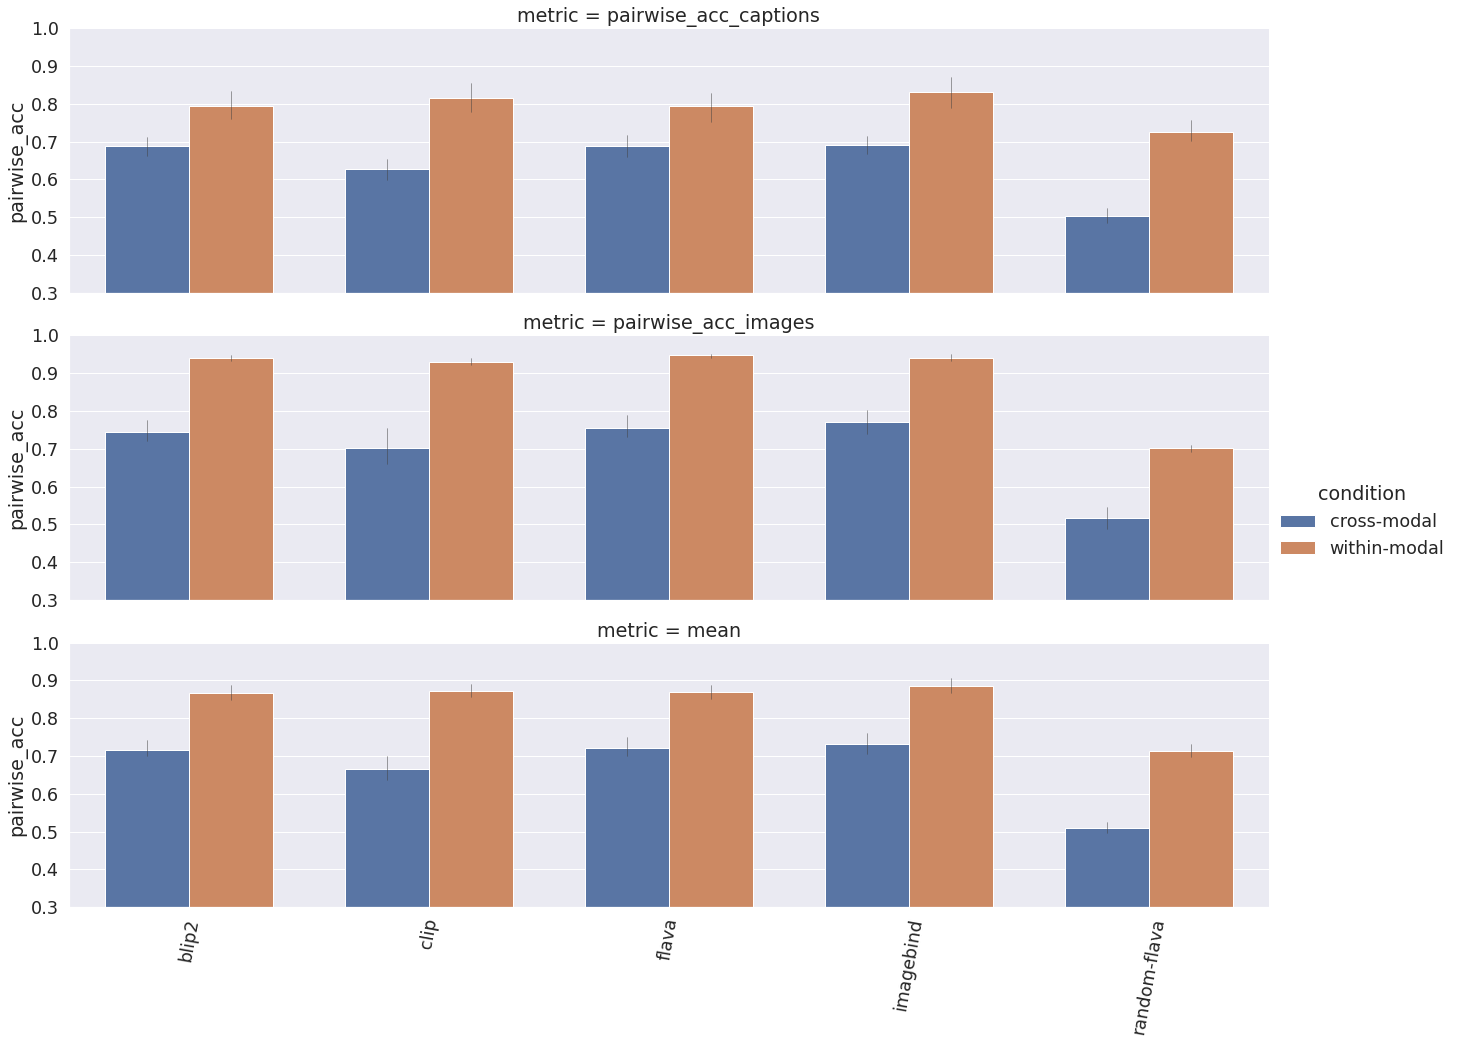

In [9]:
data_plotted = create_zero_shot_cross_modal_plot(data_matched_feats, "model", ylim=(0.3, 1))
plt.savefig(os.path.join(RESULTS_DIR, f"zero_shot_cross_modal.png"), bbox_inches='tight', pad_inches=0, dpi=300)

print(data_plotted[(data_plotted.metric == "mean")].groupby(["model", "condition"])['value'].mean())
print(data_plotted[(data_plotted.metric == "mean")].groupby(["model", "condition"])['value'].count())


# Zero-shot cross-modal decoding with Mask

In [10]:
model_order = ["blip2"]
resolution = "fsaverage7"
# model_order = ["clip", "flava", "imagebind", "blip2"]

data_models = all_data[all_data.model.isin(model_order)].copy()

# mask_name = '/home/mitja/data/multimodal_decoding/searchlight/train/blip2/avg/fsaverage7/n_neighbors_200/masks/p_values_thresh_0.01.p'
# mask_name = '/home/mitja/data/multimodal_decoding/searchlight/train/blip2/avg/fsaverage5/n_neighbors_200/masks/p_values_thresh_0.01.p'
# mask_name = '/home/mitja/data/multimodal_decoding/searchlight/train/blip2/avg/fsaverage5/n_neighbors_200/masks/p_values_thresh_0.01_left_cluster_0.p'
data_models = data_models[~pd.isna(data_models["mask"])]

data_models["mask"] = data_models["mask"].apply(lambda x: os.path.basename(x).replace("p_values_", "").replace(".p", ""))
print(data_models["mask"].unique())


# data_models = data_models[data_models["mask"] ==  mask_name]

data_models = data_models[data_models.resolution == resolution]
data_models = data_models[data_models.surface == True]
print(data_models.resolution.unique())

data_cls_feats = data_models.copy()
for model in all_data.model.unique():
    data_cls_feats = data_cls_feats[((data_cls_feats.model == model) & (data_cls_feats.vision_features == "vision_features_cls") & (data_cls_feats.lang_features == "lang_features_cls")) | (data_cls_feats.model != model)]
    # data_cls_feats = data_cls_feats[((data_cls_feats.model == model) & (data_cls_feats.vision_features == "vision_features_mean") & (data_cls_feats.lang_features == "lang_features_mean")) | (data_cls_feats.model != model)]


data_matched_feats = data_cls_feats[data_cls_feats.features == "matched"]

data_matched_feats = add_mean_cross_modal_and_within_modal_rows(data_matched_feats)

# data_matched_feats

['thresh_0.002' 'thresh_0.01' 'thresh_0.01_left_cluster_0'
 'thresh_0.01_left_cluster_1' 'thresh_0.01_left_cluster_2'
 'thresh_0.01_left_cluster_9' 'thresh_0.01_right_cluster_0'
 'thresh_0.01_right_cluster_1' 'metric_3_h_2.0_e_1.0_smoothed_0']
['fsaverage7']


mask                         condition   
thresh_0.01                  cross-modal     0.705124
                             within-modal    0.754348
thresh_0.01_left_cluster_0   cross-modal     0.652001
                             within-modal    0.712923
thresh_0.01_left_cluster_1   cross-modal     0.632609
                             within-modal    0.667012
thresh_0.01_left_cluster_2   cross-modal     0.571325
                             within-modal    0.591718
thresh_0.01_left_cluster_9   cross-modal     0.513578
                             within-modal    0.512957
thresh_0.01_right_cluster_0  cross-modal     0.545273
                             within-modal    0.552605
thresh_0.01_right_cluster_1  cross-modal     0.521239
                             within-modal    0.543513
Name: value, dtype: float64
mask                         condition   
thresh_0.01                  cross-modal     6
                             within-modal    6
thresh_0.01_left_cluster_0   cross-mod

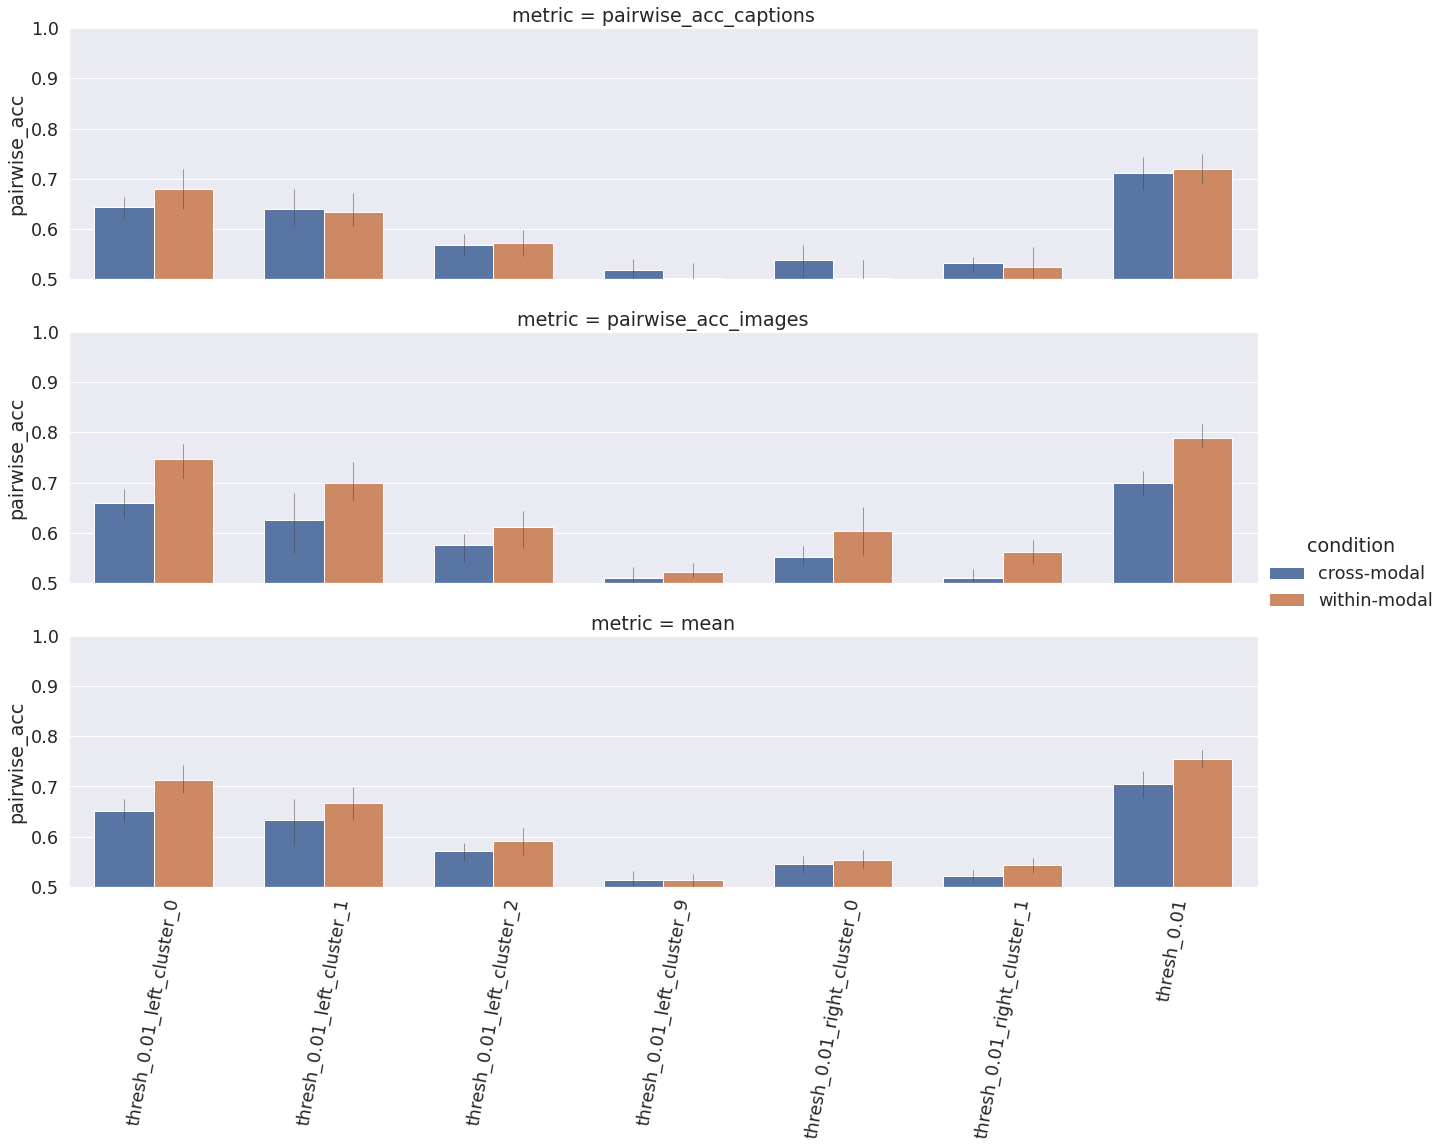

In [11]:
data_plotted = create_zero_shot_cross_modal_plot(data_matched_feats, x_variable="mask")
# plt.savefig(os.path.join(RESULTS_DIR, f"zero_shot_cross_modal_masks.png"), bbox_inches='tight', pad_inches=0, dpi=300)

print(data_plotted[(data_plotted.metric == "mean")].groupby(["mask", "condition"])['value'].mean())
print(data_plotted[(data_plotted.metric == "mean")].groupby(["mask", "condition"])['value'].count())


# Zero-shot cross-modal decoding with GloW

In [12]:
models = ["glow", "glow-contrastive"]

data_models = load_results_data(models)
data_models

100%|██████████| 1271/1271 [00:03<00:00, 367.88it/s]


,alpha,model,subject,features,vision_features,lang_features,training_mode,mask,num_voxels,metric,value,surface,model_feat
0,100000.0,glow-contrastive,sub-01,concat,vision_features_mean,lang_features_cls,modality-agnostic,None,162649,pairwise_acc_modality_agnostic,0.860352,False,glow-contrastive_concat
1,100000.0,glow-contrastive,sub-01,concat,vision_features_mean,lang_features_cls,modality-agnostic,None,162649,pairwise_acc_captions,0.822774,False,glow-contrastive_concat
2,100000.0,glow-contrastive,sub-01,concat,vision_features_mean,lang_features_cls,modality-agnostic,None,162649,pairwise_acc_images,0.936025,False,glow-contrastive_concat
3,100000.0,glow-contrastive,sub-01,concat,vision_features_mean,lang_features_cls,modality-agnostic,None,162649,pairwise_acc_mean,0.879400,False,glow-contrastive_concat
4,100000.0,glow-contrastive,sub-01,lang,vision_features_mean,lang_features_cls,modality-agnostic,None,162649,pairwise_acc_modality_agnostic,0.859006,False,glow-contrastive_lang
...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,100000.0,glow,sub-07,matched,vision_features_mean,lang_features_cls,images,None,214739,pairwise_acc_mean,0.863354,False,glow_matched
572,100000.0,glow,sub-07,vision,vision_features_mean,lang_features_cls,images,None,214739,pairwise_acc_modality_agnostic,0.811801,False,glow_vision
573,100000.0,glow,sub-07,vision,vision_features_mean,lang_features_cls,images,None,214739,pairwise_acc_captions,0.746584,False,glow_vision
574,100000.0,glow,sub-07,vision,vision_features_mean,lang_features_cls,images,None,214739,pairwise_acc_images,0.955694,False,glow_vision


In [13]:
data_cls_feats = data_models.copy()
# for model in all_data.model.unique():
#     data_cls_feats = data_cls_feats[((data_cls_feats.model == model) & (data_cls_feats.vision_features == "vision_features_cls") & (data_cls_feats.lang_features == "lang_features_cls")) | (data_cls_feats.model != model)]

data_matched_feats = data_cls_feats[data_cls_feats.features == "matched"]


In [14]:
data_matched_feats = add_mean_cross_modal_and_within_modal_rows(data_matched_feats)

model
glow                0.739441
glow-contrastive    0.737629
Name: value, dtype: float64
model
glow                6
glow-contrastive    6
Name: value, dtype: int64


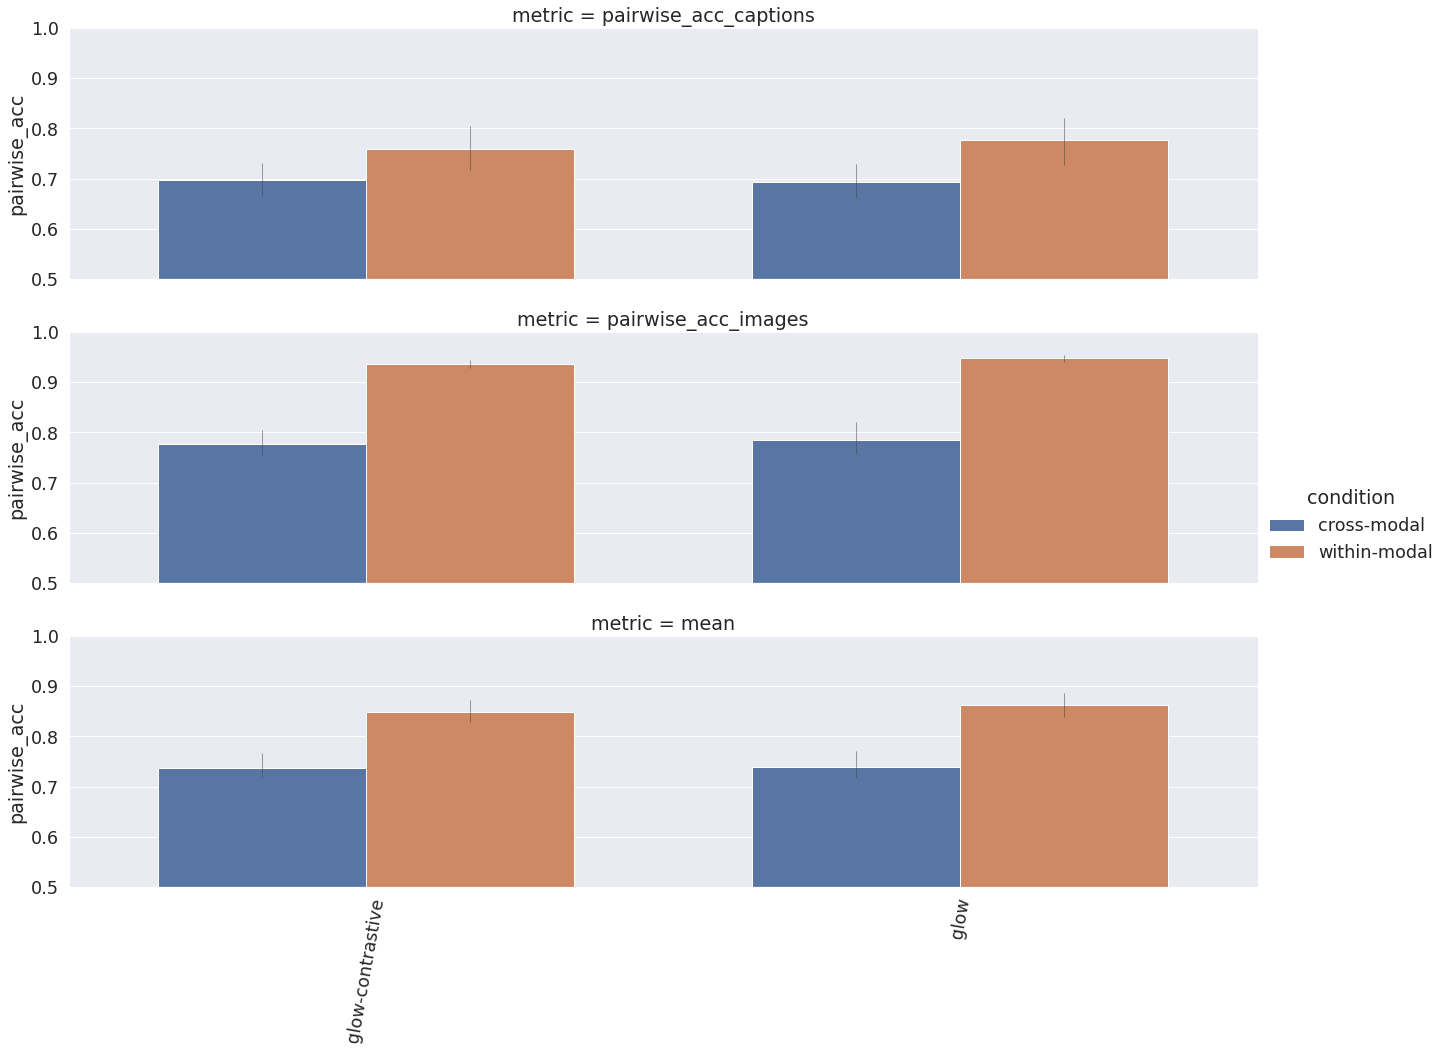

In [16]:
data_plotted = create_zero_shot_cross_modal_plot(data_matched_feats, "model")
plt.savefig(os.path.join(RESULTS_DIR, f"zero_shot_cross_modal_glow.png"), bbox_inches='tight', pad_inches=0, dpi=300)

print(data_plotted[(data_plotted.training_mode == "cross-modal") & (data_plotted.metric == "mean")].groupby("model")['value'].mean())
print(data_plotted[(data_plotted.training_mode == "cross-modal") & (data_plotted.metric == "mean")].groupby("model")['value'].count())
